## Problem Definition

We are addressing a **semantic segmentation problem**, specifically focusing on **teeth caries CT scans**. The dataset contains **teeth scans** along with their corresponding **segmentation masks**. The task involves segmenting the CT scan images to accurately identify regions affected by caries.

The objective is to develop a model that can effectively segment the images into the desired classes representing carious and non-carious regions. The challenge lies in optimizing the model's performance while managing memory constraints during training.

### Requirements:
- The model must be implemented using **`torch`** and **`torchvision`** only (no other deep learning libraries are allowed for the model architecture).
- The main class for the model must be named <font color='red'>**`Model`**</font>, and participants <font color='red'>**must not change this name**</font>.
- Do not change the init function inside the `Model` class.
- The size of your model must not exceed 70 MB.
- Instantiating your model must not require any parameters.


## Dataset

### Downloading the Teeth Dataset

First the dataset need to be downloaded.

In [1]:
!pip install datasets tqdm -q
from huggingface_hub import login
from datasets import load_dataset
from huggingface_hub import snapshot_download
import os
import sys
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00


In [2]:
dataset_id="RayanAi/Main_teeth_dataset"
# Set the local directory where you want to store the dataset
local_dataset_dir = "./Main_teeth_dataset"  # You can change this path to your desired location

# Create the directory if it doesn't exist
os.makedirs(local_dataset_dir, exist_ok=True)

# Suppress the output by redirecting it to os.devnull
with open(os.devnull, 'w') as fnull:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to devnull to suppress output
        sys.stdout = fnull
        # Download the dataset and store it locally
        snapshot_download(repo_id=dataset_id, local_dir=local_dataset_dir, repo_type="dataset")
    finally:
        # Restore the original stdout
        sys.stdout = original_stdout

# Print message when download is complete
print("Dataset downloaded completely.")

# Calculate and print the total size of the downloaded files
total_size = 0
for dirpath, dirnames, filenames in os.walk(local_dataset_dir):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

# Convert size to MB and print
print(f"Total size of downloaded files: {total_size / (1024 * 1024):.2f} MB")

# Get the absolute path of the dataset directory and print it
dataset_abs_path = os.path.abspath(local_dataset_dir)
print(f"Dataset has been saved at: [{dataset_abs_path}]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Main_teeth_dataset.zip:   0%|          | 0.00/90.2M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Dataset downloaded completely.
Total size of downloaded files: 86.07 MB
Dataset has been saved at: [/content/Main_teeth_dataset]


In [3]:
!unzip -q ./Main_teeth_dataset/Main_teeth_dataset.zip -d ./Main_teeth_dataset/

### Handling Dataset

In [4]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
#Define the split ratio
split_ratio = 0.8


#Write a Dataset function called TeethSegmentationDataset
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. Use A.Compose. Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
            noisy_masks (list, optional): Provide a list of names for images you want to be excluded from dataset
        """
        # In your dataset class __init__ method
        # Initialize paths and transformation
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.dataset_type = dataset_type

        # List of all images and masks
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        # Filter out noisy masks if provided
        if noisy_masks:
            self.images = [img for img in self.images if img not in noisy_masks]
            self.masks = [mask for mask in self.masks if mask not in noisy_masks]
        number_of_samples = len(self.images)

        if dataset_type == 'Train':
            self.images = self.images[:int(number_of_samples*split_ratio)]
            self.masks = self.masks[:int(number_of_samples*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.images[int(number_of_samples*split_ratio):]
            self.masks = self.masks[int(number_of_samples*split_ratio):]



    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        # Return the length of the dataset (number of images)
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - mask (torch.Tensor): Mask tensor for segmentation.
        """
        # Load the image and mask
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        # Load image and mask as grayscale
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        binary_mask = mask.unsqueeze(2)>0
        binary_mask = binary_mask.permute(2, 0, 1).float()

        return image, binary_mask

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
######################augmenters######################
#You may want to alter this part
augmenter = A.Compose(
    [
      A.HorizontalFlip(),                       # Random horizontal flip
      #A.VerticalFlip(p=0.5),                         # Random vertical flip
      A.RandomRotate90(p=0.1),                       # Random rotation
      #A.Rotate(limit=15, p=0.5),                     # Small rotation
      #A.RandomBrightnessContrast(p=0.2),             # Random brightness and contrast adjustments
      #A.Blur(blur_limit=3, p=0.1),                   # Random blur
      #A.ElasticTransform(alpha=1, sigma=50, p=0.1),  # Elastic deformation
      A.ColorJitter(brightness=0.1, contrast=0.1),
      A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
      ToTensorV2(),
    ]
)

######################################################

######################################################
#Don't touch this part
test_augmenter = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])
######################################################

train_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=augmenter,
    dataset_type='Train',

)

test_dataset = TeethSegmentationDataset(
    image_dir= "./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=test_augmenter,
    dataset_type='Test',

)

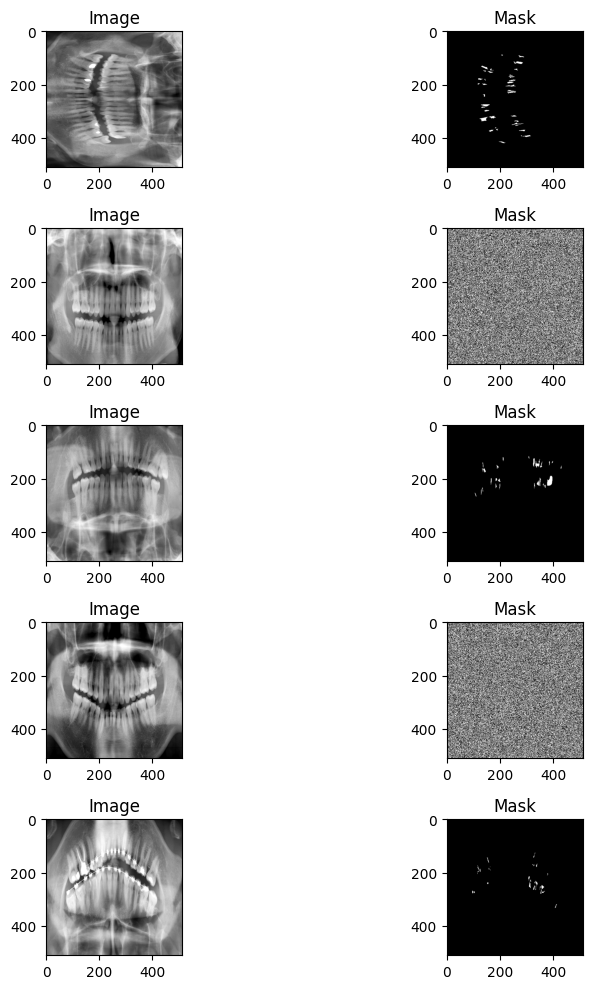

Image Means: [-0.14353539  0.18690279  0.1587097  -0.32626313  0.35055685  0.59290004
  0.03941252 -0.12418575  0.26782531  0.57037795  0.3958475   0.326888
 -0.34553689 -0.14690442 -0.47018826  0.51369286 -0.23465186  0.1839316
  0.20698184  0.04002855  0.3318246   0.15726142 -0.18242091  0.68922055
  0.35298395  0.12841448  0.2476669  -0.09103914 -0.18058801  0.10565781
  0.0048211   0.2006969  -0.21363631  0.12598239  0.4160915  -0.46563181
  0.15954652  0.28902736 -0.09639546 -0.33902311  0.06167091  0.4399581
 -0.2645936  -0.33600432  0.22948369  0.14079078 -0.17963156  0.43884337
  0.45884582  0.4947623   0.22633249  0.26068747  0.08602963  0.22616097
  0.20704776  0.27877253 -0.42627999  0.319985    0.03900104  0.10851359
  0.02569131 -0.25749367 -0.34093747 -0.19443557  0.02261597 -0.46750548
  0.22167373  0.38228416 -0.2346126   0.10898465 -0.36145502  0.31059697
  0.47544426  0.33646443 -0.16138263 -0.59462166  0.16221356 -0.47943577
 -0.10777926  0.6821987   0.08618668  0.30

In [6]:
# Dataset Examination for Data Poisoning Detection
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np

# Visualize a random sample of images and masks to manually inspect for anomalies
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))
    for i in range(num_samples):
        img, mask = dataset[i]
        axes[i, 0].imshow(img.squeeze(), cmap='gray')
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 0].set_title('Image')
        axes[i, 1].set_title('Mask')
    plt.tight_layout()
    plt.show()

# Call this function to inspect some images
visualize_samples(train_dataset)

# Function to check for anomalies in the dataset (basic statistical outliers detection)
def detect_anomalies(dataset):
    image_means = []
    mask_sums = []
    for img, mask in DataLoader(dataset, batch_size=1):
        image_means.append(img.mean().item())
        mask_sums.append(mask.sum().item())
    return np.array(image_means), np.array(mask_sums)

image_means, mask_sums = detect_anomalies(train_dataset)
print("Image Means:", image_means)
print("Mask Sums:", mask_sums)


In [7]:
# Data Cleaning based on detected anomalies
def clean_dataset(dataset, image_means, mask_sums, mean_threshold=2.0, mask_sum_threshold=50):
    # Assuming each element in dataset contains an image and a mask
    clean_data = []
    for idx, (img, mask) in enumerate(dataset):
        im_mean = image_means[idx]
        m_sum = mask_sums[idx]
        # Filter based on specified thresholds
        if abs(im_mean - np.mean(image_means)) < mean_threshold and m_sum > mask_sum_threshold:
            clean_data.append((img, mask))
    return clean_data

# Example of using the cleaning function with the corrected version
train_dataset_cleaned = clean_dataset(train_dataset, image_means, mask_sums)


In [8]:
from torch.utils.data import DataLoader
batch_size=4
num_workers=0 # Increase this if you have a powerfull cpu
dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
  'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 482
Test dataset size: 121


# Segmentation model
In this part you should design a segmentation model. If you have defined any functions used to define your model, you should upload it along the model code.

Your model shouldn't take any inputs or produce outputs when instantiating.

<font color='red'>Important: You can only use functions availble in `torch` and `torchvision`.</font>

In [10]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Encoder layers
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 320)

        # Decoder layers
        self.dec4 = self.upconv_block(320, 256)
        self.dec3 = self.upconv_block(256, 128)
        self.dec2 = self.upconv_block(128, 64)
        self.dec1 = self.upconv_block(64, 32)

        # Output layer
        self.output = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # Efficient block with depthwise separable convolutions
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            self.conv_block(out_channels, out_channels)
        )

    #######DO NOT CHANGE THIS PART########
    def init(self):
        self.load_state_dict(torch.load('model.pth',weights_only=True))
    ######################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder with skip connections for detail retention
        dec4 = self.dec4(bottleneck) + enc4
        dec3 = self.dec3(dec4) + enc3
        dec2 = self.dec2(dec3) + enc2
        dec1 = self.dec1(dec2) + enc1

        # Final output
        mask = self.output(dec1)
        return mask

In [11]:
model = Model().to(device)

image = next(iter(dataloaders['train']))[0].to(device)
out = model(image)
print(image.shape)
print(out.shape)
assert image.shape == (batch_size, 1, 512, 512), "You shouldn't change the size of the image"
assert out.shape == (batch_size, 1, 512, 512), "The output of your model do not have correct dimensions"

torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])


## Dice Score

**Here** is the dice score function. You model is evaluated based on the score from this function

In [12]:
def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
    """
    Computes the Dice score between the predicted and target segmentation masks.

    Args:
        pred (torch.Tensor): The predicted mask tensor, with values in range [0, 1].
        target_one_target_maskhot (torch.Tensor): The ground truth mask.
        epsilon (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The Dice score, a similarity metric between 0 and 1.
    """
    pred = pred>0
    pred_flat = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_mask.contiguous().view(target_mask.shape[0], target_mask.shape[1], -1)

    intersection = (pred_flat * target_flat).sum(dim=-1)
    union = pred_flat.sum(dim=-1) + target_flat.sum(dim=-1)

    dice = (2. * intersection + epsilon) / (union + epsilon)

    dice_mean = dice.mean(dim=1)

    return dice_mean.mean()

In [13]:
class UNetLoss(nn.Module):
    def __init__(self, epsilon: float = 1e-6):
        super(UNetLoss, self).__init__()
        self.epsilon = epsilon
        self.bce_loss = nn.BCELoss()

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Computes the combined loss (BCE + Dice Loss).

        Args:
            pred (torch.Tensor): The predicted mask tensor (logits).
            target (torch.Tensor): The ground truth mask tensor.

        Returns:
            torch.Tensor: The computed loss.
        """
        # Apply sigmoid to get probabilities
        pred_prob = torch.sigmoid(pred)

        # Compute Binary Cross-Entropy Loss
        bce = self.bce_loss(pred_prob, target)

        # Compute Dice Loss
        pred_flat = pred_prob.view(pred.shape[0], -1)
        target_flat = target.view(target.shape[0], -1)

        intersection = (pred_flat * target_flat).sum(dim=-1)
        union = pred_flat.sum(dim=-1) + target_flat.sum(dim=-1)

        dice_loss = 1 - (2. * intersection + self.epsilon) / (union + self.epsilon)

        # Return the combined loss
        return bce + dice_loss.mean()

## Training

In [16]:
#Define your optimizer and loss function
#You can either use predefined loss functions or define one your self

criterion = UNetLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

#Define a learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decrease learning rate every 10 epochs


In [17]:
import matplotlib.pyplot as plt
def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
    # Convert tensors to numpy for visualization
    sample_index = 0  # Index of the sample to visualize
    channel = 0
    print(f'Dice score is {dice_score(outputs[sample_index:sample_index+1,channel:channel+1],masks[sample_index:sample_index+1,channel:channel+1])}')

    inputs_np = inputs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = outputs.detach().cpu().numpy()

    # Choose a sample to visualize

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np[sample_index].transpose(1, 2, 0), cmap='gray')  # Assuming inputs are in CxHxW format
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[sample_index, channel], cmap='gray')  # Display the first channel of the mask
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs_np[sample_index, channel]>0, cmap='gray')  # Display the first channel of the output
    plt.title("Model Output Mask")
    plt.axis('off')

    plt.show()

The `train_model` function implements a simple training loop that iterates over a specified number of epochs. In each iteration, the model is trained on the training set and then evaluated on the validation set using the Dice score as the performance metric. The function returns the model as it is at the final epoch.

Epoch 0/24
----------
train Loss: 1.4709
Dice score is 0.017443012446165085


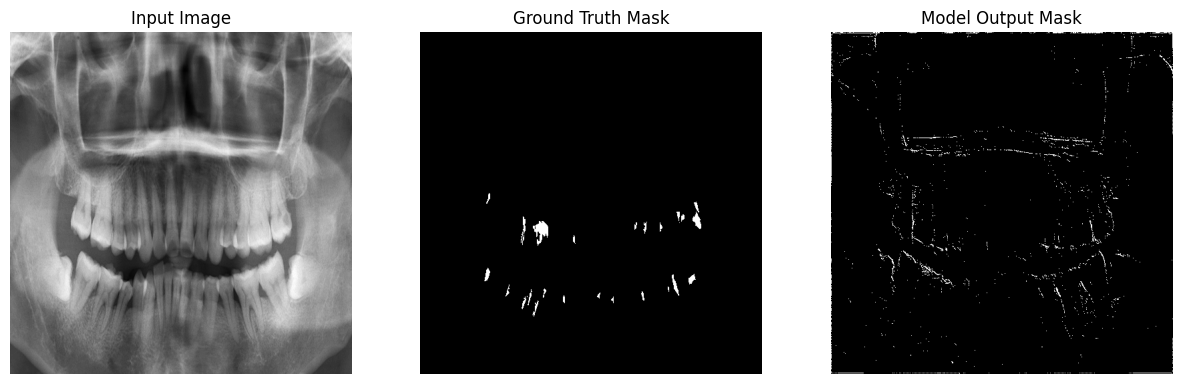

test Loss: 1.4045
Dice score: 0.026049738749861717
Epoch 1/24
----------
train Loss: 1.3890
Dice score is 0.0025542788207530975


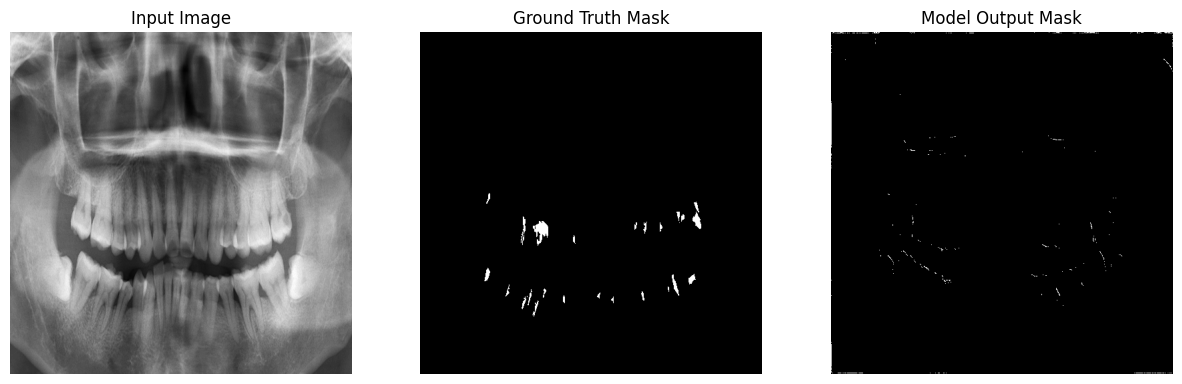

test Loss: 1.3747
Dice score: 0.01650276407599449
Epoch 2/24
----------
train Loss: 1.3665
Dice score is 5.813953207756128e-10


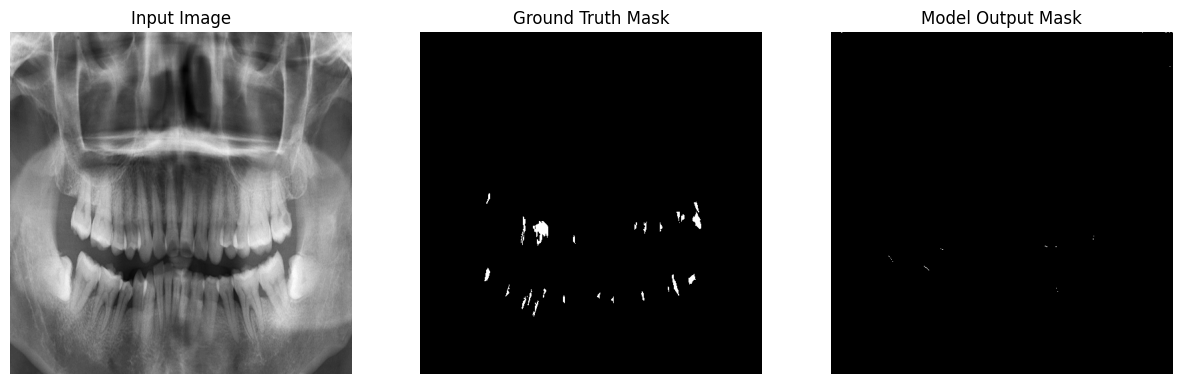

test Loss: 1.3637
Dice score: 0.004681343212723732
Epoch 3/24
----------
train Loss: 1.3607
Dice score is 5.899705168843639e-10


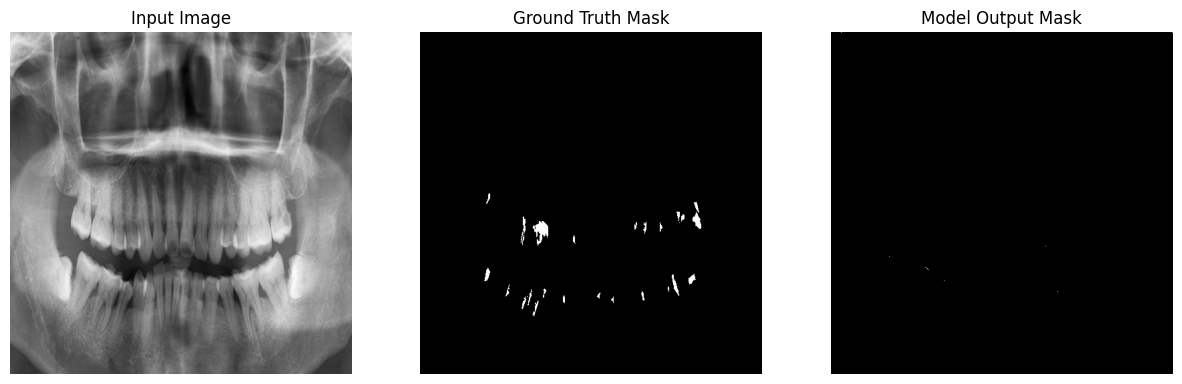

test Loss: 1.3610
Dice score: 0.004300056491047144
Epoch 4/24
----------
train Loss: 1.3569
Dice score is 5.924170598525791e-10


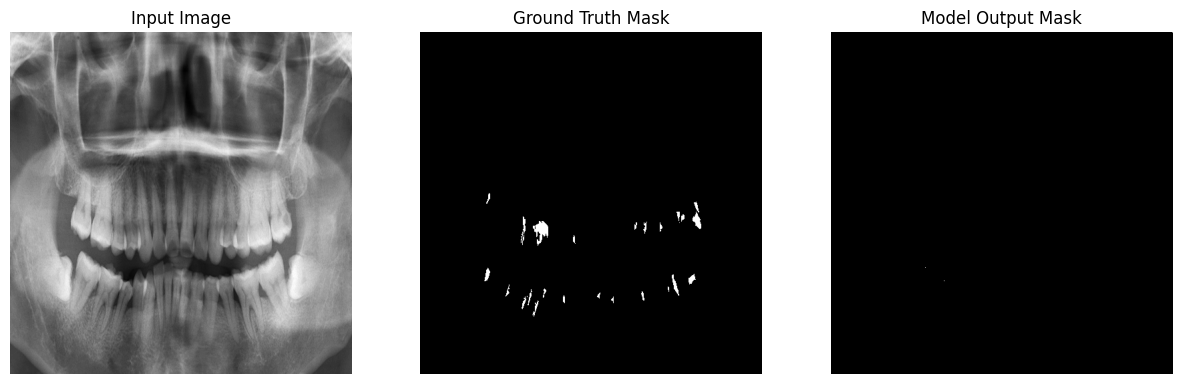

test Loss: 1.3601
Dice score: 0.003782808780670166
Epoch 5/24
----------
train Loss: 1.3557
Dice score is 5.903187938471888e-10


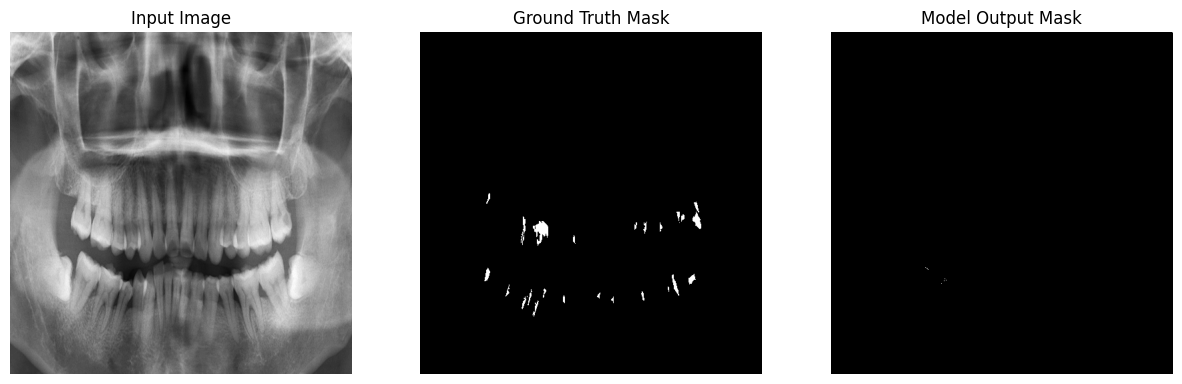

test Loss: 1.3597
Dice score: 0.0033274879679083824
Epoch 6/24
----------
train Loss: 1.3549
Dice score is 5.92768223395268e-10


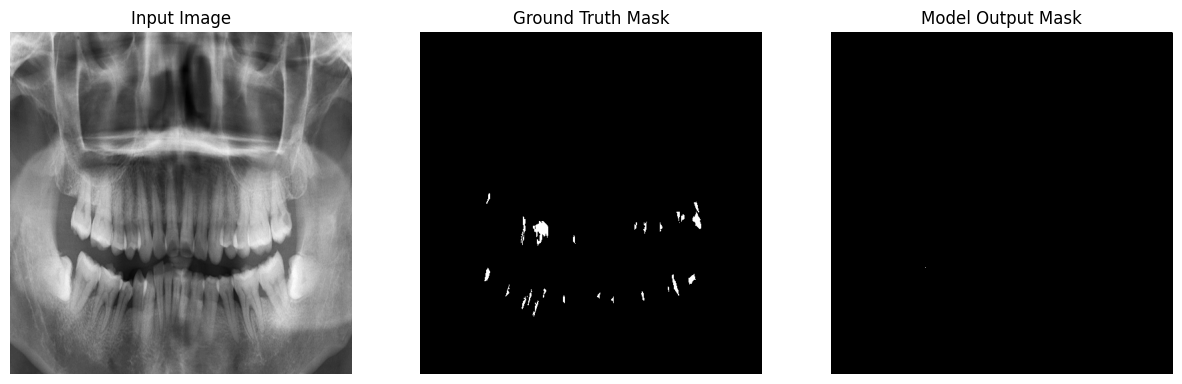

test Loss: 1.3601
Dice score: 0.0002757073089014739
Epoch 7/24
----------
train Loss: 1.3549
Dice score is 5.931198310271668e-10


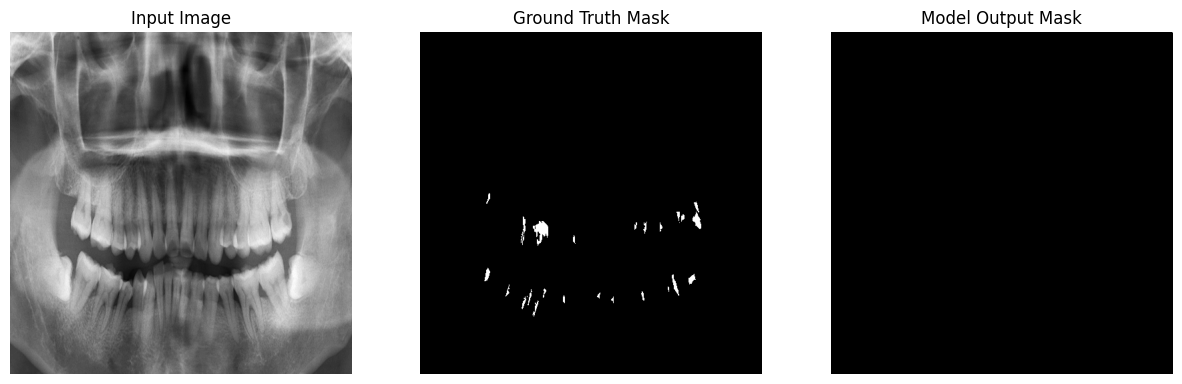

test Loss: 1.3602
Dice score: 4.9915990530280396e-05
Epoch 8/24
----------
train Loss: 1.3541
Dice score is 5.92768223395268e-10


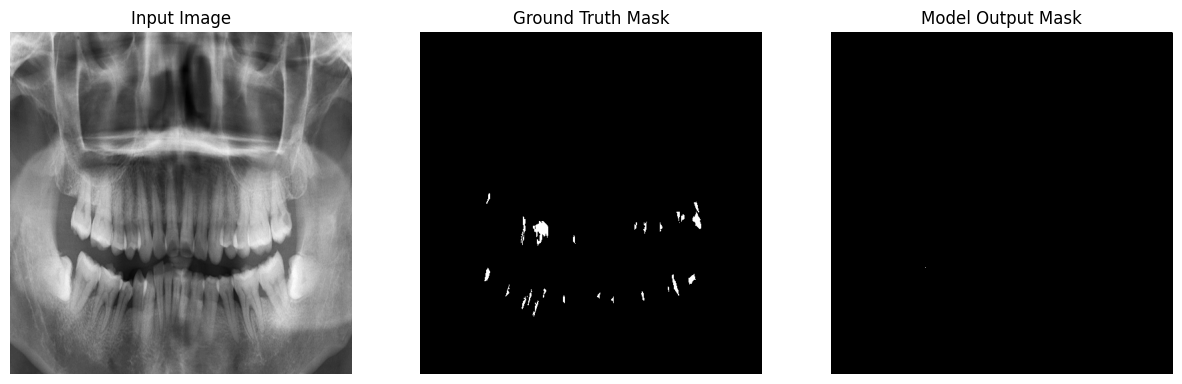

test Loss: 1.3613
Dice score: 0.00010838354501174763
Epoch 9/24
----------
train Loss: 1.3535
Dice score is 5.934718272371242e-10


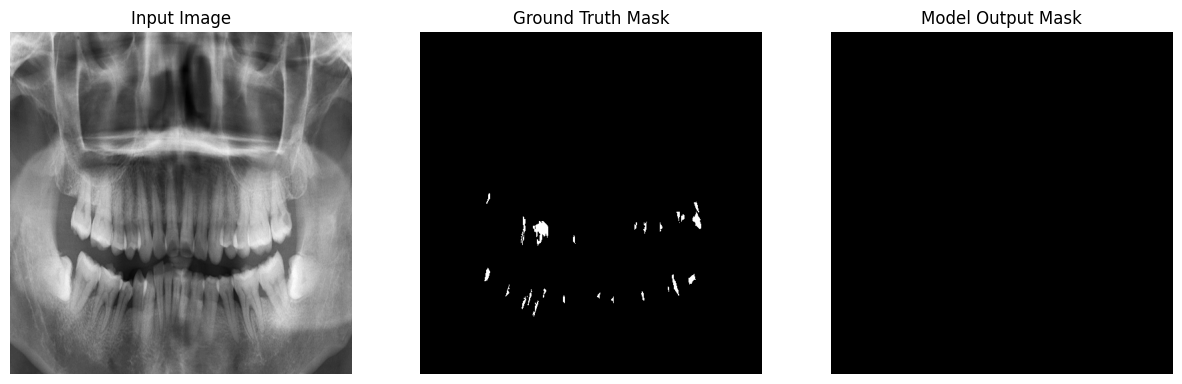

test Loss: 1.3603
Dice score: 0.003758000209927559
Epoch 10/24
----------
train Loss: 1.3534
Dice score is 5.931198310271668e-10


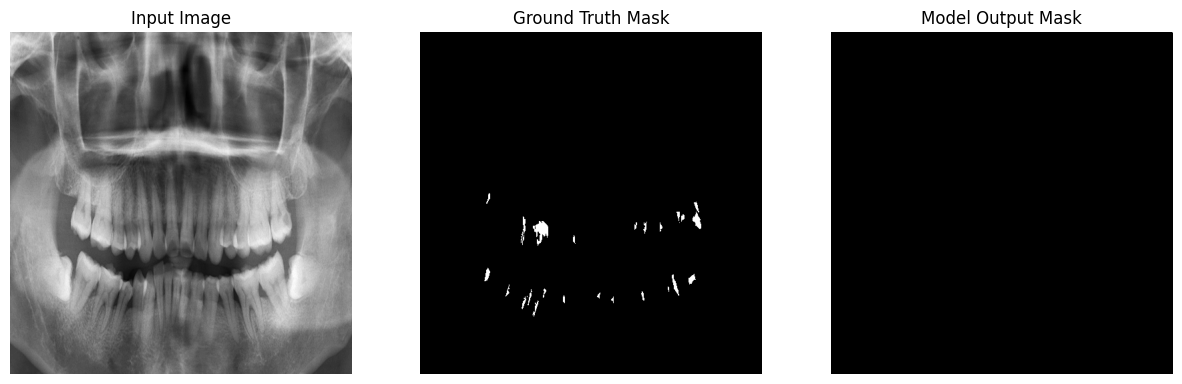

test Loss: 1.3600
Dice score: 5.107759716338478e-05
Epoch 11/24
----------
train Loss: 1.3529
Dice score is 5.931198310271668e-10


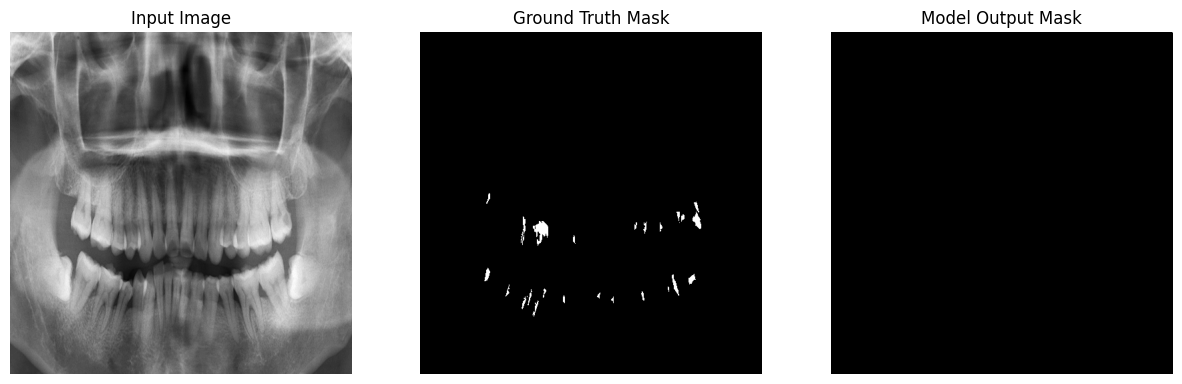

test Loss: 1.3596
Dice score: 0.00124276801943779
Epoch 12/24
----------
train Loss: 1.3529
Dice score is 0.0035523984115570784


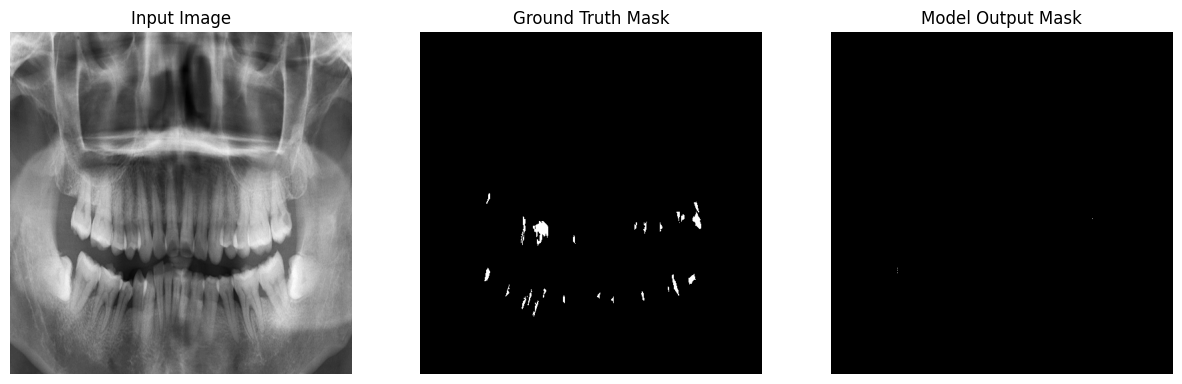

test Loss: 1.3595
Dice score: 0.0010524134850129485
Epoch 13/24
----------
train Loss: 1.3509
Dice score is 0.036464087665081024


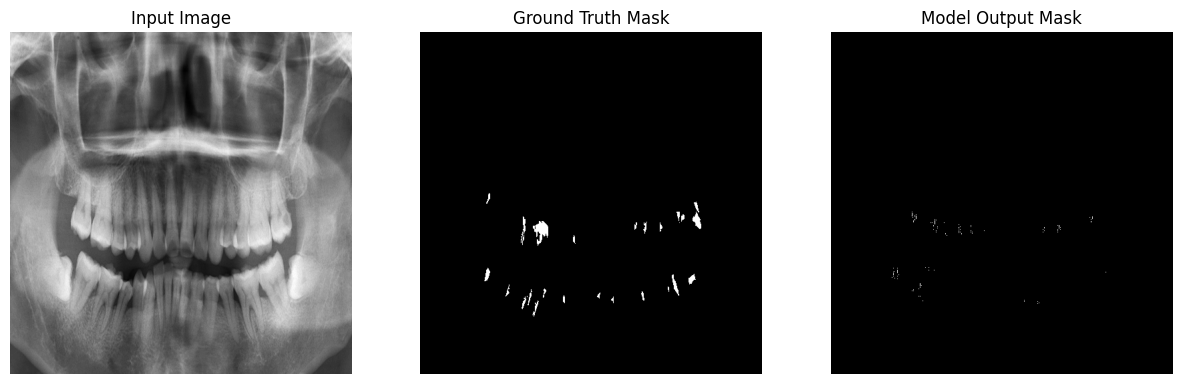

test Loss: 1.3598
Dice score: 0.025989629328250885
Epoch 14/24
----------
train Loss: 1.3537
Dice score is 0.009296921081840992


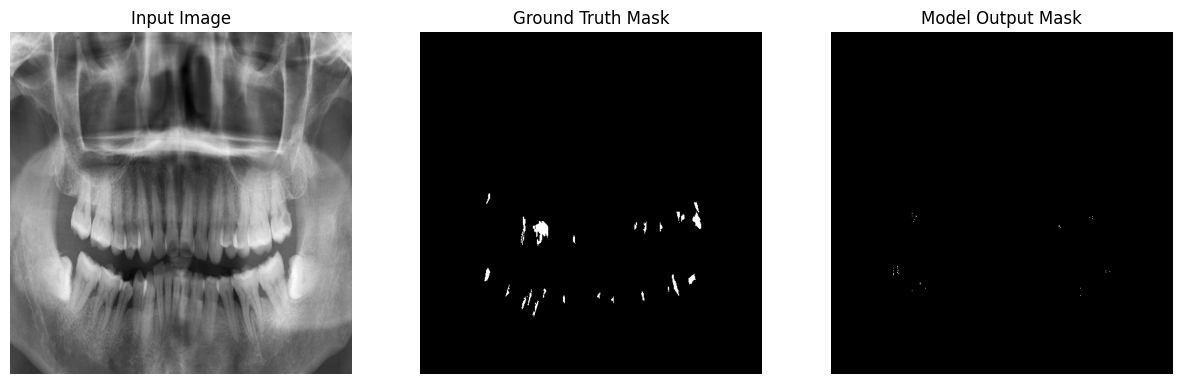

test Loss: 1.3577
Dice score: 0.008298703469336033
Epoch 15/24
----------
train Loss: 1.3518
Dice score is 0.029916897416114807


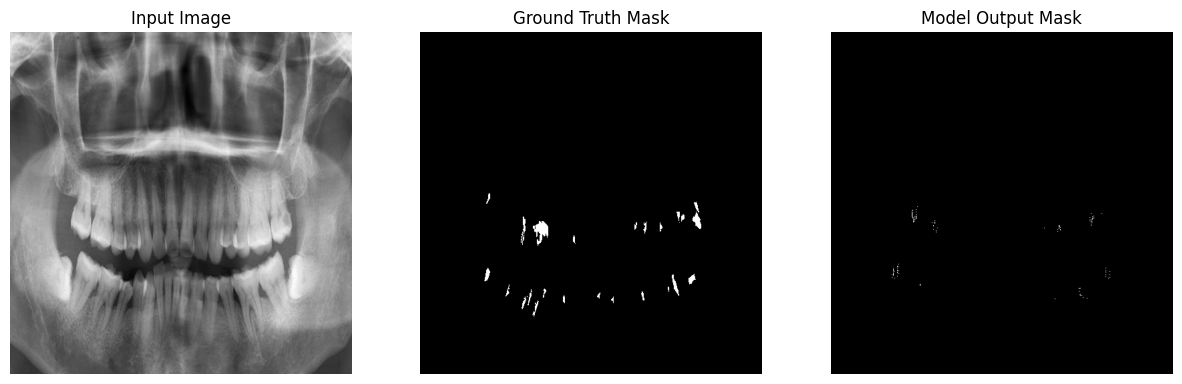

test Loss: 1.3597
Dice score: 0.024541320279240608
Epoch 16/24
----------
train Loss: 1.3517
Dice score is 0.0718623474240303


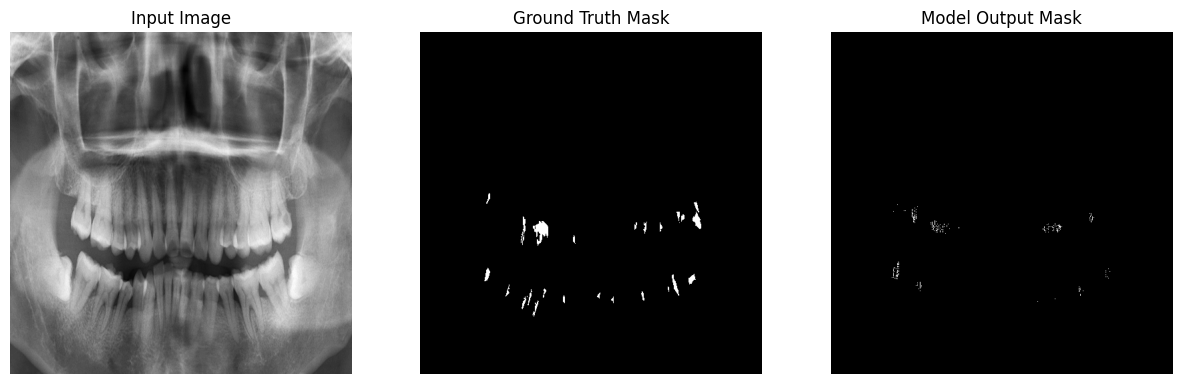

test Loss: 1.3584
Dice score: 0.057455819100141525
Epoch 17/24
----------
train Loss: 1.3507
Dice score is 0.26861515641212463


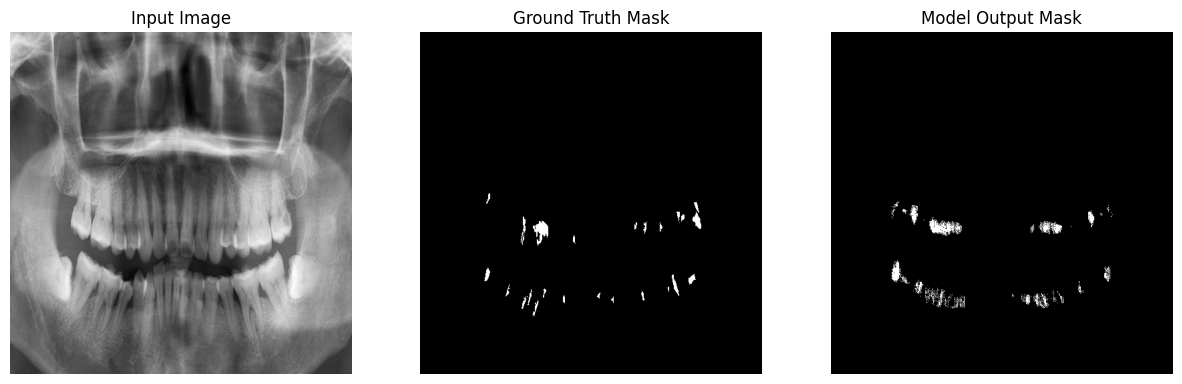

test Loss: 1.3589
Dice score: 0.13719594478607178
Epoch 18/24
----------
train Loss: 1.3502
Dice score is 0.2777118384838104


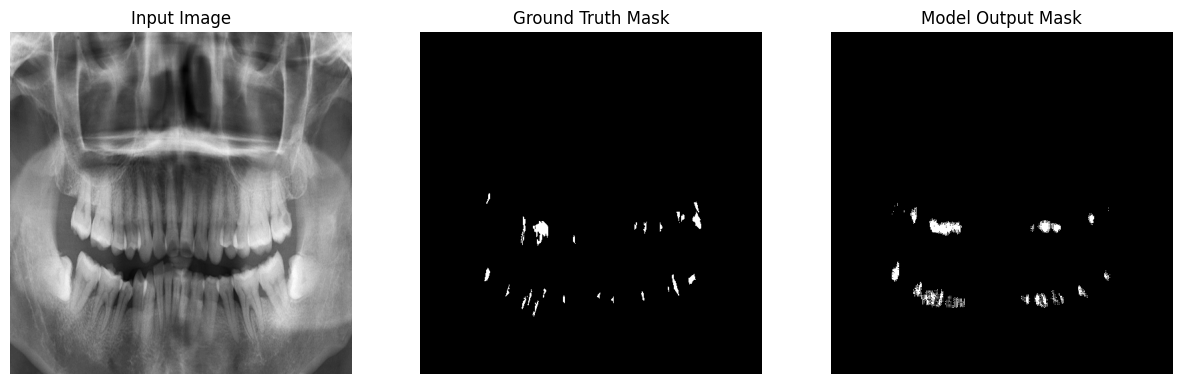

test Loss: 1.3578
Dice score: 0.14535991847515106
Epoch 19/24
----------
train Loss: 1.3492
Dice score is 0.32424676418304443


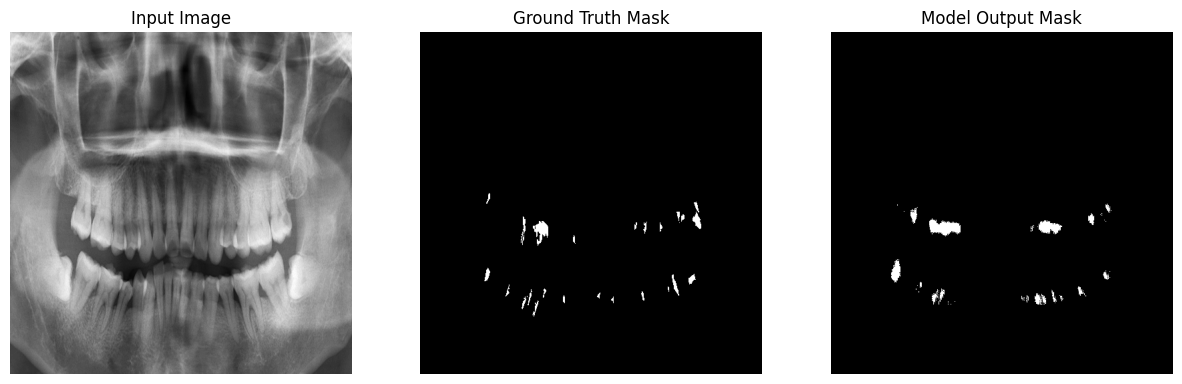

test Loss: 1.3569
Dice score: 0.16449841856956482
Epoch 20/24
----------
train Loss: 1.3489
Dice score is 0.33636364340782166


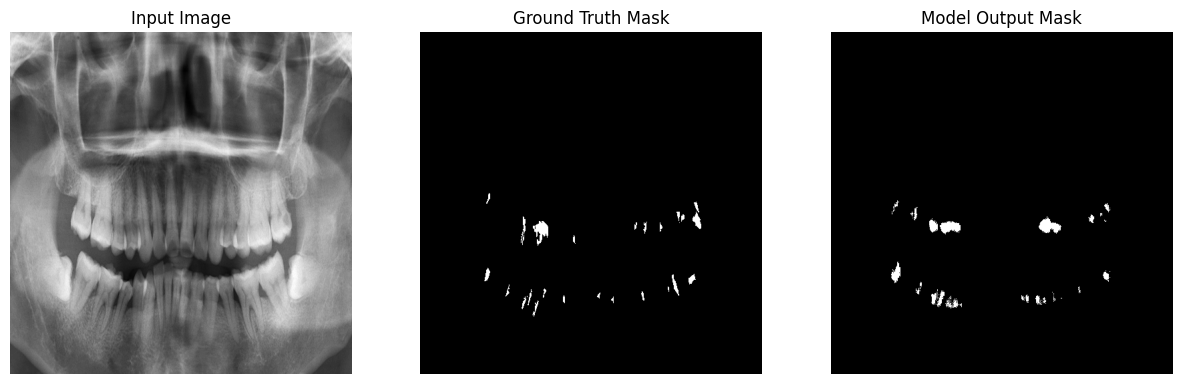

test Loss: 1.3565
Dice score: 0.16769516468048096
Epoch 21/24
----------
train Loss: 1.3483
Dice score is 0.323655903339386


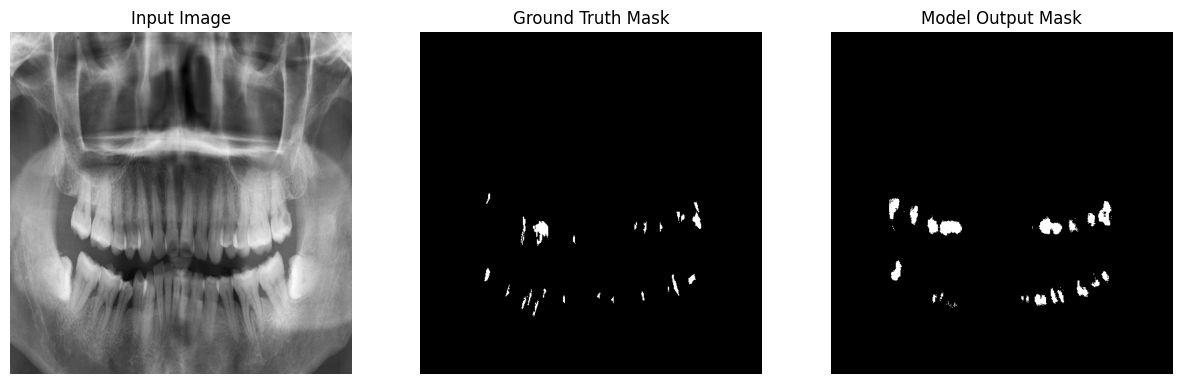

test Loss: 1.3567
Dice score: 0.18378975987434387
Epoch 22/24
----------
train Loss: 1.3471
Dice score is 0.3574158251285553


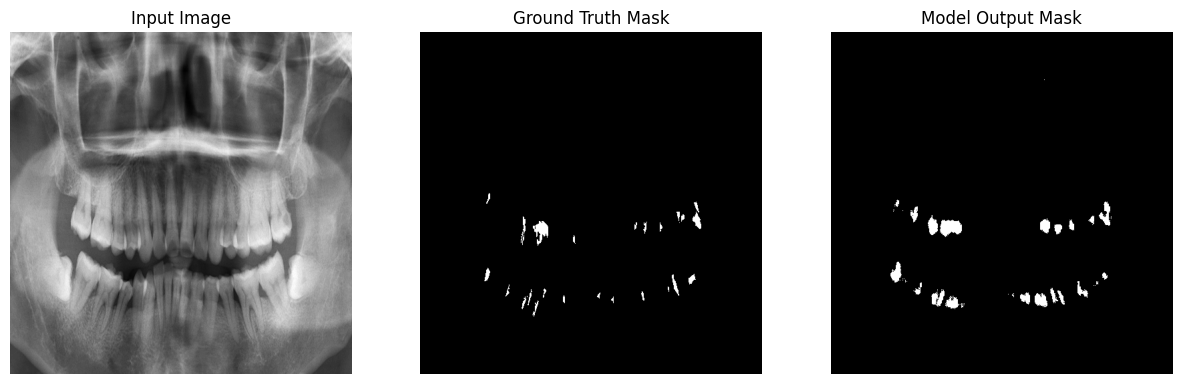

test Loss: 1.3552
Dice score: 0.201191246509552
Epoch 23/24
----------
train Loss: 1.3462
Dice score is 0.3126186430454254


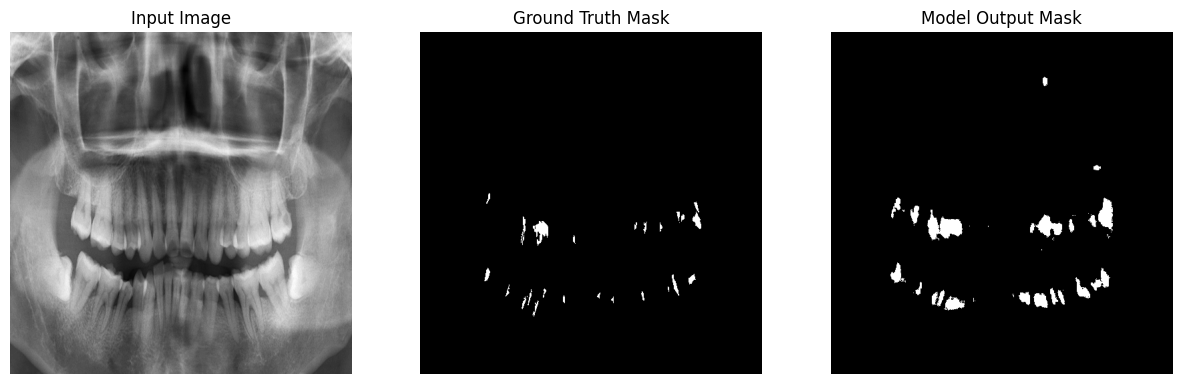

test Loss: 1.3571
Dice score: 0.1788874715566635
Epoch 24/24
----------
train Loss: 1.3454
Dice score is 0.3433994948863983


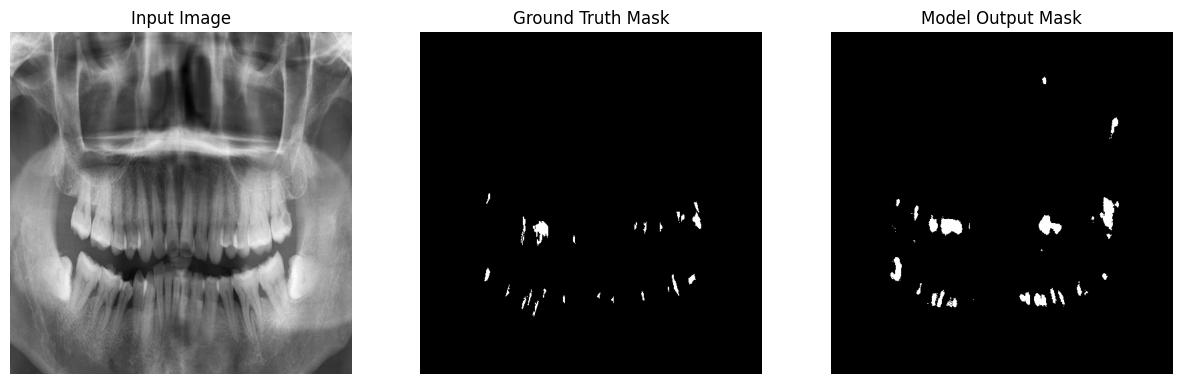

test Loss: 1.3539
Dice score: 0.20416304469108582
Training complete in 15m 0s


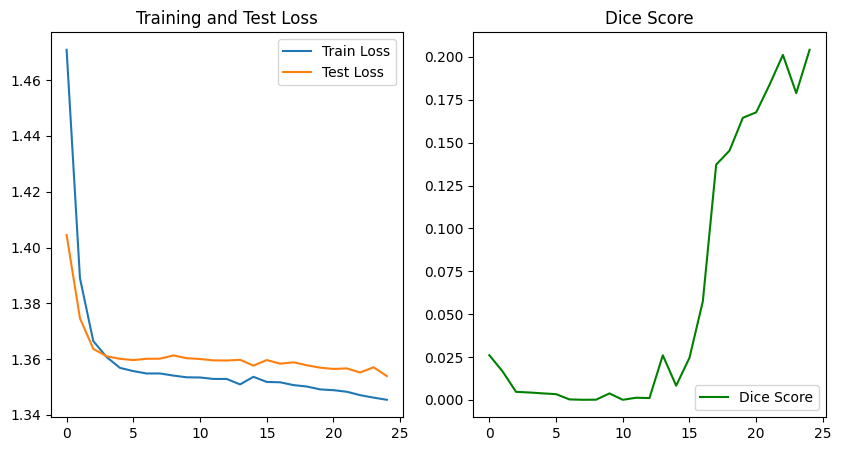

In [18]:
import torch
import time
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim


model = model.to(device)  # Move model to GPU if available

# Training function with visualization support
def train_model(
    model: nn.Module,
    dataloaders: dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int = 25
) -> nn.Module:
    """
    Trains the model over a specified number of epochs using the given data loaders,
    criterion (loss function), and optimizer.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        dataloaders (dict[str, DataLoader]): A dictionary containing 'train' and 'test' data loaders.
        criterion (nn.Module): The loss function to be used for training.
        optimizer (torch.optim.Optimizer): The optimizer used to adjust model parameters.
        num_epochs (int, optional): Number of epochs for training. Defaults to 25.

    Returns:
        nn.Module: The trained model.
    """
    since = time.time()

    train_losses = []
    test_losses = []
    dice_scores_epoch = []

    for epoch in range(num_epochs):
        dice_scores = []
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs,masks)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        dice_scores.append(dice_score(outputs, masks))

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            # Step the scheduler
            #scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)
                dice_scores_epoch.append(torch.tensor(dice_scores).mean().item())

                visualize_mask(inputs, masks, outputs)


            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == 'test':
                print(f'Dice score: {torch.tensor(dice_scores).mean()}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot the results
    epochs_range = range(num_epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, test_losses, label="Test Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Test Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, dice_scores_epoch, label="Dice Score", color="green")
    plt.legend(loc="lower right")
    plt.title("Dice Score")

    plt.show()

    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer)

In [19]:
model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)

In [20]:
import zipfile

with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('model.pth')
    zipf.write('model.py')